# 第六题





## 一、 按照4、5题分析，打印BTCUSDT:binance（1H）因子分析报告

读取BTCUSDT:binance（1H）数据

In [1]:
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}
Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


**1.以Alpha191——alpha003的10条均线突破综合打分，设定进、出场条件**

In [2]:
# 添加alpha3因子
_ = dv.add_formula('alpha3',"Ts_Sum(If((close==Delay(close,%s)),0,close-(If((close>Delay(close,%s)),Min(low,Delay(close,%s)),Max(high,Delay(close,%s))))),%s)"%(1,1,1,1,6),add_data=True)

In [3]:
# 获取得分
import pandas as pd
import numpy as np
import talib as ta

def get_score(alpha3):
    alpha3=alpha3.values
    signal_df=pd.DataFrame({t: ((alpha3>ta.MA(alpha3, t))&(alpha3>0)&(alpha3<300)).astype(np.int16) for t in np.arange(1,11)})
    return signal_df.sum(axis=1).values


alpha3=dv.get_ts('alpha3')
score_df=pd.DataFrame(data=get_score(alpha3['BTCUSDT:binance']), index=alpha3.index, columns=alpha3.columns)
dv.append_df(score_df, 'score')

In [4]:
#进场、退场信号设定
long = dv.add_formula('long','If( (score>=5) && (Delay(score,1)<5) && (Delay(score,2)<5) , 2, 0)', add_data=True)
short = dv.add_formula('short','If( (score<=1) && (Delay(score,1)>1) && (Delay(score,2)>1) , -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [5]:
#计算绩效
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

C:\Python\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Python\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Python\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Python\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Python\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Python\lib\site-packages\ipykernel\kernelapp.py", line 497, in start
    self.io_loop.start()
  File "C:\Python\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.as

In [6]:
#分析报告--long
tdAlpha_BTC = TimingDigger(output_folder=".", output_format='pdf',signal_name='AlphaStatistic_BTC')
TimingSignal(tdAlpha_BTC, dv, 100, 0.1, 0.3)
tdAlpha_BTC.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 9%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               11.194  -12.728   -0.094
p-value               0.000    0.000    0.925
mean                  0.018   -0.015   -0.000
std                   0.025    0.020    0.028
info_ratio            0.707   -0.730   -0.004
skewness              3.003   -2.809    0.675
kurtosis             10.761    8.912    8.323
pct5                  0.000   -0.056   -0.041
pct25                 0.003   -0.018   -0.008
pct50                 0.009   -0.007   -0.001
pct75                 0.022   -0.004    0.007
pct95                 0.057   -0.001    0.040
occurance           252.000  305.000  557.000
win_ratio               NaN      NaN    0.452
win_mean/loss_mean      NaN      NaN    1.194


In [7]:
#分析报告--short
tdAlpha_BTC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               10.842  -12.826    0.642
p-value               0.000    0.000    0.521
mean                  0.019   -0.013    0.001
std                   0.025    0.017    0.026
info_ratio            0.752   -0.776    0.029
skewness              2.238   -3.313    0.876
kurtosis              5.046   14.930    6.825
pct5                  0.000   -0.038   -0.032
pct25                 0.003   -0.016   -0.008
pct50                 0.009   -0.007   -0.001
pct75                 0.024   -0.004    0.007
pct95                 0.078   -0.001    0.044
occurance           209.000  274.000  483.000
win_ratio               NaN      NaN    0.433
win_mean/loss_mean      NaN      NaN    1.446


In [8]:
#分析报告--long_short
tdAlpha_BTC.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               15.590  -17.930     0.353
p-value               0.000    0.000     0.724
mean                  0.018   -0.014     0.000
std                   0.025    0.019     0.027
info_ratio            0.727   -0.746     0.011
skewness              2.651   -3.033     0.758
kurtosis              8.096   11.225     7.747
pct5                  0.000   -0.048    -0.036
pct25                 0.003   -0.016    -0.008
pct50                 0.009   -0.007    -0.001
pct75                 0.023   -0.004     0.007
pct95                 0.070   -0.001     0.041
occurance           461.000  579.000  1040.000
win_ratio               NaN      NaN     0.443
win_mean/loss_mean      NaN      NaN     1.304


**2.以蜡烛图判断进场、退场信号**

In [9]:
import talib as ta
import matplotlib.pyplot as plt
import mpl_finance as mpf
warnings.filterwarnings('ignore')

from matplotlib.pylab import date2num
data = Time_dict.set_index('datetime')
data['candleTime'] = list(map(date2num, data.index))
candle = data.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

def draw_candle(candle, scatterX, scatterY, marker, s, title):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=s, marker=marker)
    ax.xaxis_date ()
    ax.set_title(title)
    ax1.bar(data.index, data.volume)
    plt.show()

**更改说明：4-5题做多信号以十字启明星作为基础，这次提交将进场信号换为三内部上涨和下跌，3根k线组合阴阳阳，且第三根k线超越前一根，上涨趋势。对比蜡烛图（如下）可知该信号数量不仅比十字启明星更多，而且底部反转效果更好。**

**做空信号不变**

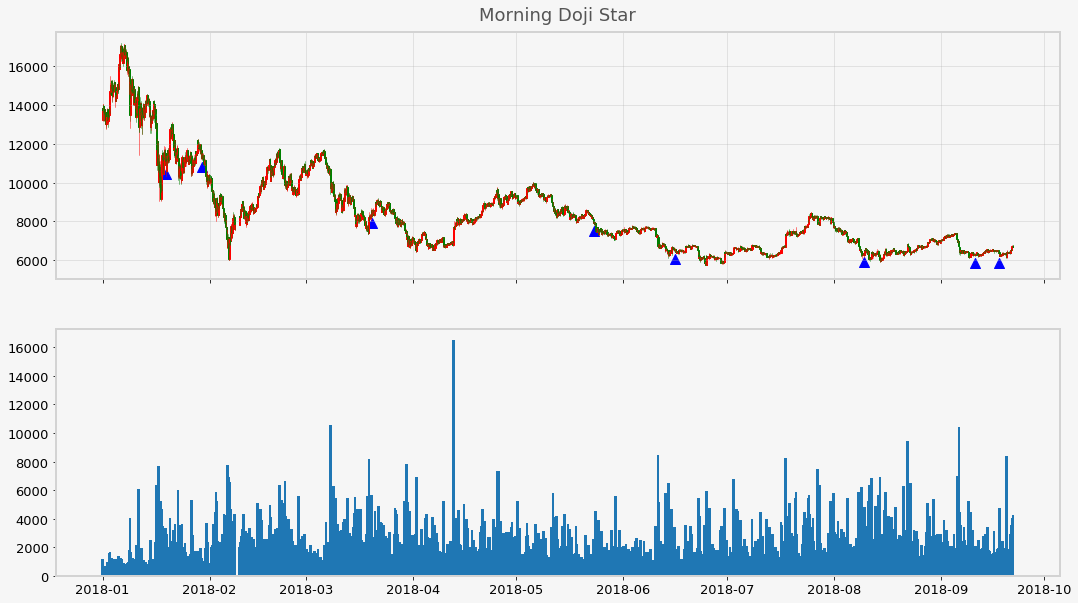

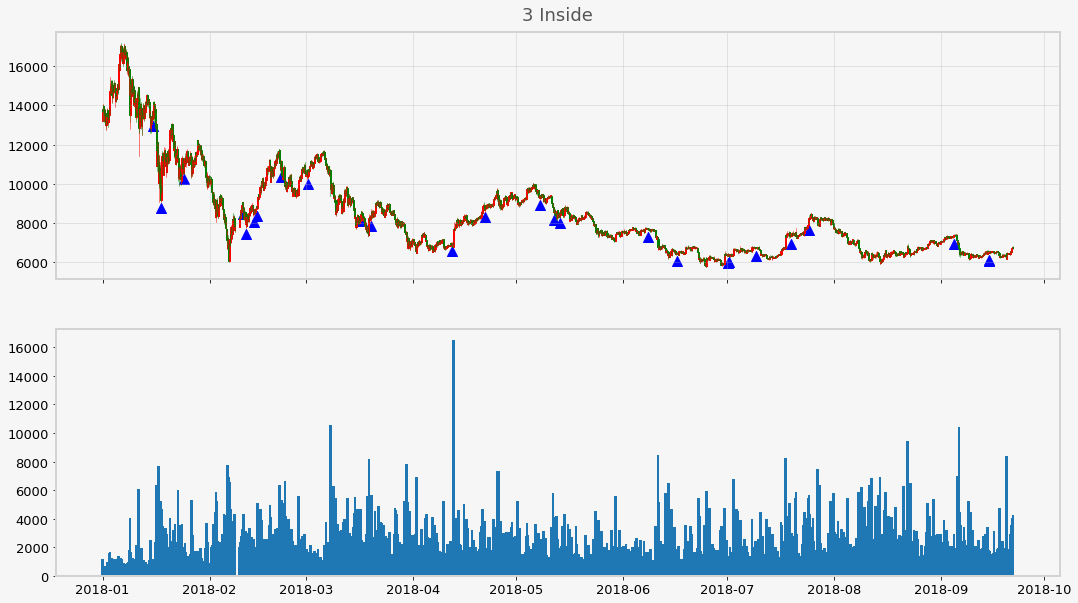

In [10]:
#更改前后做多信号蜡烛图对比

#旧做多信号
_ = dv.add_formula('morning_doji_star', "If((Ta('CDLMORNINGDOJISTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morning_doji_star = dv.get_ts('morning_doji_star', date_type='datetime')
morning_doji_star_X = morning_doji_star[morning_doji_star['BTCUSDT:binance']==100].index
morning_doji_star_Y = data.loc[morning_doji_star_X, 'low']-400
draw_candle(candle, morning_doji_star_X, morning_doji_star_Y, marker='^', s=100, title='Morning Doji Star')

#新做多信号
_ = dv.add_formula('cdl3inside', "If((Ta('CDL3INSIDE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
cdl3inside = dv.get_ts('cdl3inside', date_type='datetime')
cdl3inside_X = cdl3inside[cdl3inside['BTCUSDT:binance']==100].index
cdl3inside_Y = data.loc[cdl3inside_X, 'low']-400
draw_candle(candle, cdl3inside_X, cdl3inside_Y, marker='^', s=100, title='3 Inside')

#做空信号没变，还是吞噬形态
_ = dv.add_formula('engulfing', "If((Ta('CDLENGULFING', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

In [11]:
# 设定进出场条件
long = dv.add_formula('long','If( cdl3inside==100  , 2, 0)', add_data=True)
short = dv.add_formula('short','If( (engulfing==100) && (Return(volume,1)> 1.5) && (close>Delay(close,1)) , -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [12]:
#分析报告--long
tdCandle_BTC = TimingDigger(output_folder=".", output_format='pdf',signal_name='CandleStatistic_BTC')
TimingSignal(tdCandle_BTC, dv, 100, 0.1, 0.3)
tdCandle_BTC.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.102  -6.012   0.884
p-value              0.001   0.000   0.385
mean                 0.107  -0.079   0.021
std                  0.094   0.044   0.119
info_ratio           1.138  -1.813   0.177
skewness             0.795   0.509   0.715
kurtosis            -0.775  -1.417  -0.288
pct5                 0.018  -0.125  -0.123
pct25                0.034  -0.115  -0.093
pct50                0.067  -0.102   0.016
pct75                0.161  -0.032   0.080
pct95                0.271  -0.012   0.249
occurance           14.000  12.000  26.000
win_ratio              NaN     NaN   0.538
win_mean/loss_mean     NaN     NaN   1.353


In [13]:
#分析报告--short
tdCandle_BTC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              1.425 -2.008   0.397
p-value             0.213  0.115   0.700
mean                0.041 -0.032   0.008
std                 0.065  0.032   0.064
info_ratio          0.637 -1.004   0.126
skewness            1.722 -0.432   1.589
kurtosis            1.081 -1.771   2.786
pct5                0.002 -0.073  -0.070
pct25               0.006 -0.066  -0.007
pct50               0.017 -0.008   0.002
pct75               0.023 -0.005   0.017
pct95               0.145 -0.005   0.105
occurance           6.000  5.000  11.000
win_ratio             NaN    NaN   0.545
win_mean/loss_mean    NaN    NaN   1.294


In [14]:
#分析报告--long_short
tdCandle_BTC.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.162  -5.687   0.974
p-value              0.001   0.000   0.337
mean                 0.087  -0.065   0.017
std                  0.091   0.046   0.106
info_ratio           0.955  -1.422   0.162
skewness             1.011   0.087   0.888
kurtosis            -0.336  -1.612   0.359
pct5                 0.002  -0.124  -0.122
pct25                0.021  -0.107  -0.066
pct50                0.036  -0.069   0.002
pct75                0.157  -0.018   0.037
pct95                0.258  -0.005   0.235
occurance           20.000  17.000  37.000
win_ratio              NaN     NaN   0.541
win_mean/loss_mean     NaN     NaN   1.338


# 二、 进出场逻辑移植到EOSUSDT:binance（1H），观察绩效

读取EOSUSDT:binance（1H）数据

In [15]:
warnings.filterwarnings('ignore')
ds1 = LocalDataService()
path = r'./min_data/VnTrader_1Min_Db'
props1 = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}
Time_dict1 = ds1.bar_reader(path,props1)
dv1 = HFDataView()
dv1.create_init_dv(Time_dict1.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


**1.以Alpha191——alpha003alpha003的10条均线突破综合打分，设定进、出场条件**

In [16]:
_ = dv1.add_formula('alpha3',"Ts_Sum(If((close==Delay(close,%s)),0,close-(If((close>Delay(close,%s)),Min(low,Delay(close,%s)),Max(high,Delay(close,%s))))),%s)"%(1,1,1,1,6),add_data=True)
alpha3 = dv1.get_ts('alpha3')
score_df = pd.DataFrame(data=get_score(alpha3['EOSUSDT:binance']), index=alpha3.index, columns=alpha3.columns)
dv1.append_df(score_df, 'score')

long = dv1.add_formula('long','If( (score>=5) && (Delay(score,1)<5) && (Delay(score,2)<5) , 2, 0)', add_data=True)
short = dv1.add_formula('short','If( (score<=1) && (Delay(score,1)>1) && (Delay(score,2)>1) , -2, 0)', add_data=True)
closeLong = dv1.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [17]:
#分析报告--long
tdAlpha_EOS = TimingDigger(output_folder=".", output_format='pdf',signal_name='AlphaStatistic_EOS')
TimingSignal(tdAlpha_EOS, dv1, 100, 0.1, 0.3)
tdAlpha_EOS.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                7.235  -11.514   -1.081
p-value               0.000    0.000    0.281
mean                  0.022   -0.021   -0.002
std                   0.031    0.021    0.034
info_ratio            0.724   -1.010   -0.071
skewness              2.644   -2.004    1.084
kurtosis              7.892    4.610    5.959
pct5                  0.001   -0.066   -0.047
pct25                 0.005   -0.027   -0.018
pct50                 0.010   -0.015   -0.004
pct75                 0.031   -0.007    0.008
pct95                 0.080   -0.002    0.053
occurance           101.000  131.000  232.000
win_ratio               NaN      NaN    0.435
win_mean/loss_mean      NaN      NaN    1.040


In [18]:
#分析报告--short
tdAlpha_EOS.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               7.332  -10.853    0.067
p-value              0.000    0.000    0.947
mean                 0.027   -0.023    0.000
std                  0.037    0.023    0.039
info_ratio           0.741   -1.012    0.005
skewness             2.016   -2.052    1.129
kurtosis             3.243    6.029    4.207
pct5                 0.001   -0.062   -0.053
pct25                0.005   -0.032   -0.017
pct50                0.011   -0.016   -0.003
pct75                0.026   -0.006    0.010
pct95                0.128   -0.002    0.062
occurance           99.000  116.000  215.000
win_ratio              NaN      NaN    0.460
win_mean/loss_mean     NaN      NaN    1.189


In [19]:
#分析报告--long_short
tdAlpha_EOS.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               10.271  -15.840   -0.674
p-value               0.000    0.000    0.501
mean                  0.025   -0.022   -0.001
std                   0.034    0.022    0.036
info_ratio            0.728   -1.010   -0.032
skewness              2.298   -2.035    1.132
kurtosis              5.072    5.414    5.055
pct5                  0.001   -0.065   -0.052
pct25                 0.005   -0.029   -0.018
pct50                 0.010   -0.016   -0.003
pct75                 0.028   -0.006    0.009
pct95                 0.104   -0.002    0.058
occurance           200.000  247.000  447.000
win_ratio               NaN      NaN    0.447
win_mean/loss_mean      NaN      NaN    1.118


**2.以蜡烛图判断进场、退场信号**

In [20]:
_ = dv1.add_formula('cdl3inside', "If((Ta('CDL3INSIDE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
_ = dv1.add_formula('engulfing', "If((Ta('CDLENGULFING', 0, open, high, low, close, volume)==100),100,0)", add_data=True)


long = dv1.add_formula('long','If( cdl3inside==100  , 2, 0)', add_data=True)
short = dv1.add_formula('short','If( (engulfing==100) && (Return(volume,1)> 1.5) && (close>Delay(close,1)) , -2, 0)', add_data=True)
closeLong = dv1.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv1.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [21]:
#分析报告--long
tdCandle_EOS = TimingDigger(output_folder=".", output_format='pdf',signal_name='CandleStatistic_EOS')
TimingSignal(tdCandle_EOS, dv1, 100, 0.1, 0.3)
tdCandle_EOS.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              1.653 -7.554 -0.282
p-value             0.240  0.005  0.787
mean                0.101 -0.099 -0.013
std                 0.087  0.023  0.115
info_ratio          1.169 -4.361 -0.115
skewness            0.675  0.943  0.975
kurtosis           -1.500 -0.861 -0.242
pct5                0.032 -0.117 -0.117
pct25               0.040 -0.116 -0.109
pct50               0.051 -0.109 -0.061
pct75               0.137 -0.092  0.040
pct95               0.206 -0.067  0.171
occurance           3.000  4.000  7.000
win_ratio             NaN    NaN  0.429
win_mean/loss_mean    NaN    NaN  1.020


In [22]:
#分析报告--short
tdCandle_EOS.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              1.705 -2.817  0.139
p-value             0.230  0.217  0.896
mean                0.068 -0.086  0.006
std                 0.056  0.030  0.089
info_ratio          1.206 -2.817  0.070
skewness            0.268 -0.000  0.141
kurtosis           -1.500 -2.000 -1.162
pct5                0.010 -0.113 -0.104
pct25               0.031 -0.101 -0.055
pct50               0.057 -0.086  0.005
pct75               0.099 -0.071  0.057
pct95               0.132 -0.058  0.124
occurance           3.000  2.000  5.000
win_ratio             NaN    NaN  0.600
win_mean/loss_mean    NaN    NaN  0.787


In [23]:
#分析报告--long_short
tdCandle_EOS.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              2.522 -8.045  -0.163
p-value             0.053  0.000   0.874
mean                0.084 -0.095  -0.005
std                 0.075  0.026   0.106
info_ratio          1.128 -3.598  -0.049
skewness            0.839  0.613   0.712
kurtosis           -0.715 -1.490  -0.491
pct5                0.011 -0.117  -0.117
pct25               0.035 -0.116  -0.106
pct50               0.054 -0.109  -0.025
pct75               0.120 -0.071   0.053
pct95               0.202 -0.057   0.178
occurance           6.000  6.000  12.000
win_ratio             NaN    NaN   0.500
win_mean/loss_mean    NaN    NaN   0.891
